# **Water Management and Forecasting**
### **Project Backgroung**
The arid climate of several Algerian regions and the water-stressed region of Bhopal, effective water management and forecasting are crucial. This project aims to harness the power of machine learning to address the unique water resource challenges faced by both regions. By creating an open-source solution, we aim to empower Algeria and Bhopal to make informed decisions, optimize resource allocation, and build resilient water infrastructure for a sustainable future.
### **Project Goals**
**Develop a Comprehensive Open-Source Water Management and Forecasting System:** Create a user-friendly platform tailored to the specific needs of Algeria and Bhopal, integrating machine learning algorithms for precise water forecasting and efficient water resource management.

- **Enhance Water Resource Utilization:** Improve the sustainable use of water resources in both regions by providing accurate forecasts and real-time monitoring.
- **Capacity Building:** Empower local stakeholders in Algeria and Bhopal with the knowledge and tools necessary to make well-informed decisions about water management.
- **Community Engagement:** Foster collaboration among local government agencies, NGOs, and the research community to collectively address water-related challenges in both regions.

# **Summary of Data Processing**
* GFS, GLDAS and population datasets were merged into one
* The final dataset is collected from 2015 April 1 to December June 30 with the below dates missing due to data absence:</br>
{
'2015-04-10', '2015-04-11', '2015-04-12', '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-17', '2015-04-18', '2015-04-19', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31', '2022-12-31'
}
* 'SWE_tavg', 'SnowDepth_tavg', 'Qsb_tavg', 'Qsm_tavg', 'EvapSnow_tavg' were dropped
* A new feature **'water_availability'** is created and use it as a target variable (For details, see below **Feature Engineering** section)
* The dataset was split into train and test datasets: train --> 2015 to 2021, test --> 2022 & 2023
* Save them in train_bhopal.csv and test_bhopal.csv respectively
* train_bhopal.csv: 2435 rows, 28 columns
* test_bhopal.csv: 545 rows, 28 columns 

**Data Source:**
###### * https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25
###### * https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V022_CLSM_G025_DA1D


# **Import Modules**

In [1]:
#### Import the libraries needed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

# **Set Environment**

In [2]:
import plotly.io as pio
pio.renderers.default = "vscode"

In [3]:
# Set up directory
working_directory = Path.cwd()
src = working_directory.parents[1]
# data directory
raw_data_directory = src / 'data' / 'raw'
processed_data_directory = src / 'data' / 'processed'
final_data_directory = src / 'data' / 'final'

In [7]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Set default title color
plt.style.use('fivethirtyeight')

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# suptitle
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams['text.color'] = '#333333'
# title
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams['axes.titlecolor'] = '#333333'
# label
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.labelcolor'] = '#333333'
# spines
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# tick
plt.rcParams['xtick.color'] = "#333333"
plt.rcParams['ytick.color'] = "#333333"
# line width
plt.rcParams['lines.linewidth'] = 1

## **Load all Open Meteo Datasets and Merge into gfs_df**

In [6]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'open-meteo-23.23N77.45E495m_2015_2023.csv')
open_df = pd.read_csv(file)
open_df['date'] = pd.to_datetime(open_df['time'], format='%m/%d/%Y')
open_df.drop('time', axis=1, inplace=True)
open_df.head()

,precipitation_sum (mm),date
0,0.0,2015-04-01
1,0.0,2015-04-02
2,0.0,2015-04-03
3,0.0,2015-04-04
4,0.0,2015-04-05


## **Load all GFS Datasets and Merge into gfs_df**

* **temperature_2m_above_ground (°C)**: Temperature 2m above ground
* **specific_humidity_2m_above_ground (%)**: Specific humidity 2m above ground
* **relative_humidity_2m_above_ground (%)**: Relative humidity 2m above ground
* **u_component_of_wind_10m_above_ground (m/s)**: U component of wind 10m above ground
* **v_component_of_wind_10m_above_ground (m/s)**: V component of wind 10m above ground
* **total_precipitation_surface (kg/m^2)**: Cumulative precipitation at surface for the previous 1-6 hours, depending on the value of the "forecast_hours" property according to the formula ((F - 1) % 6) + 1 (and only for assets with forecast_hours > 0)
* **precipitable_water_entire_atmosphere (kg/m^2)**: Precipitable water for entire atmosphere
* **total_cloud_cover_entire_atmosphere (%)**: Total cloud cover for entire atmosphere (only for assets with forecast_hours > 0)
* **downward_shortwave_radiation_flux (W/m^2)**: Downward shortwave radiation flux (only for assets with forecast_hours > 0)

In [7]:
# save result in list -> all_filenames
bhopal_filenames = [file_name for file_name in glob.glob(str(raw_data_directory) + "/*.csv") if os.path.basename(file_name).startswith('GFS_Bhopal')]

# Combine all files in the list
gfs_df = pd.concat([pd.read_csv(f) for f in bhopal_filenames])

In [8]:
# Convert the 'date' columns to datetime data type
gfs_df['date'] = pd.to_datetime(gfs_df['date'], format='%y-%m-%d')

In [9]:
gfs_df.shape

(3147, 9)

In [10]:
gfs_df.head()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
0,2015-04-01,Bhopal,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0
1,2015-04-02,Bhopal,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0
2,2015-04-03,Bhopal,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0
3,2015-04-04,Bhopal,30.046127,0.008165,30.080859,2.575579,-1.547093,24.770628,0.0
4,2015-04-05,Bhopal,30.523074,0.007366,26.557658,-0.549178,-0.442961,23.765168,0.0


In [11]:
gfs_df.tail()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
343,2023-12-10,Bhopal,18.811834,0.006121,43.662294,-1.405728,-0.565707,12.593095,0.000389
344,2023-12-11,Bhopal,18.872122,0.006296,44.810857,-1.503734,-0.283899,14.011080,0.028797
345,2023-12-12,Bhopal,18.785527,0.005872,42.018555,-1.647457,-0.419264,13.332485,0.010552
346,2023-12-13,Bhopal,18.444809,0.005759,42.108677,-1.865238,-0.799219,14.464455,0.015756
347,2023-12-14,Bhopal,18.650056,0.005858,42.060450,-1.756230,-0.815621,13.921977,0.000171


### **Missing Value Handling**
* Fill in missing values between '2015-04-10' and '2015-04-19' with the month average
* Fill in missing values between '2021-12-15' and '2021-12-31' with the month average
* Fill in missing values on December 31 for 8 years with each year's December average

In [12]:
gfs_df['date'] = pd.to_datetime(gfs_df['date'], format="%Y-%m-%d")
print(f"First date: {gfs_df['date'].min()}")
print(f"Last date: {gfs_df['date'].max()}")

First date: 2015-04-01 00:00:00
Last date: 2023-12-14 00:00:00


In [13]:
# Check missing dates
start_date = gfs_df['date'].min()
end_date = gfs_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))

df_date_set = set(d.strftime("%Y-%m-%d") for d in gfs_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"Dataset has {len(missing_dates)} missing days")
missing_dates

Dataset has 33 missing days


{'2015-04-10',
 '2015-04-11',
 '2015-04-12',
 '2015-04-13',
 '2015-04-14',
 '2015-04-15',
 '2015-04-16',
 '2015-04-17',
 '2015-04-18',
 '2015-04-19',
 '2016-12-31',
 '2017-12-31',
 '2018-12-31',
 '2019-12-31',
 '2020-12-31',
 '2021-12-15',
 '2021-12-16',
 '2021-12-17',
 '2021-12-18',
 '2021-12-19',
 '2021-12-20',
 '2021-12-21',
 '2021-12-22',
 '2021-12-23',
 '2021-12-24',
 '2021-12-25',
 '2021-12-26',
 '2021-12-27',
 '2021-12-28',
 '2021-12-29',
 '2021-12-30',
 '2021-12-31',
 '2022-12-31'}

In [14]:
# Drop 'city'
gfs_df.drop('city', inplace=True, axis=1)

In [15]:
# Get April 2015 and December 2021 average
avg_2015_4 = gfs_df[(gfs_df['date'].dt.year == 2015) & (gfs_df['date'].dt.month == 4)].mean()
avg_2021_12 = gfs_df[(gfs_df['date'].dt.year == 2021) & (gfs_df['date'].dt.month == 12)].mean()

In [16]:
dates_2015_4 = pd.date_range('2015-4-10', '2015-4-19')
# Create a DataFrame with the dates as the index and the series as the data
df_2015_4 = pd.DataFrame(index=dates_2015_4, data={key: [value]*len(dates_2015_4) for key, value in avg_2015_4.items()})
# Replace 'date' 
df_2015_4['date'] = dates_2015_4
df_2015_4.reset_index(drop=True, inplace=True)

dates_2021_12 = pd.date_range('2021-12-15', '2021-12-31')
# Create a DataFrame with the dates as the index and the series as the data
df_2021_12 = pd.DataFrame(index=dates_2021_12, data={key: [value]*len(dates_2021_12) for key, value in avg_2021_12.items()})
# Replace 'date' 
df_2021_12['date'] = dates_2021_12 
df_2021_12.reset_index(drop=True, inplace=True)

In [17]:
# Fill December 31
dates_12_31 = ['2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2022-12-31']
dates_12_31 = pd.to_datetime(dates_12_31)

# Initialize a dictionary to store the averages
december_averages = {}

# Loop over the dates
for date in dates_12_31:
    # Filter the DataFrame for the month of December for the specific year
    december_data = gfs_df[(gfs_df['date'].dt.month == 12) & (gfs_df['date'].dt.year == date.year)]
    
    # Calculate the mean and store it in the dictionary
    december_averages[date.year] = december_data.mean()

# Convert the dictionary to a DataFrame
december_averages_df = pd.DataFrame(december_averages).T.reset_index(drop=True)

# Replace 'date' with dates_12_31
december_averages_df['date'] = dates_12_31

In [18]:
gfs_missing_data = pd.concat([df_2015_4, df_2021_12], axis=0, ignore_index=True)
gfs_missing_data = pd.concat([gfs_missing_data, december_averages_df], axis=0, ignore_index=True)

In [19]:
gfs_df = pd.concat([gfs_missing_data, gfs_df], axis=0).sort_values('date')
gfs_df.iloc[9:19]

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
0,2015-04-10,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
1,2015-04-11,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
2,2015-04-12,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
3,2015-04-13,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
4,2015-04-14,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
5,2015-04-15,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
6,2015-04-16,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
7,2015-04-17,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
8,2015-04-18,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098
9,2015-04-19,33.488036,0.005383,16.823614,2.795207,-1.628356,18.392761,0.001098


In [20]:
gfs_df.shape

(3180, 8)

In [21]:
print(f"First date: {gfs_df['date'].min()}")
print(f"Last date: {gfs_df['date'].max()}")

First date: 2015-04-01 00:00:00
Last date: 2023-12-14 00:00:00


In [22]:
# Check missing dates
start_date = gfs_df['date'].min()
end_date = gfs_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))

df_date_set = set(d.strftime("%Y-%m-%d") for d in gfs_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"Dataset has {len(missing_dates)} missing days")
missing_dates

Dataset has 0 missing days


set()

In [23]:
cols = gfs_df.select_dtypes(include=['object']).columns
gfs_df[cols] = gfs_df[cols].apply(pd.to_numeric, errors='coerce')
gfs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3180 entries, 0 to 347
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  3180 non-null   datetime64[ns]
 1   temperature_2m_above_ground           3180 non-null   float64       
 2   specific_humidity_2m_above_ground     3180 non-null   float64       
 3   relative_humidity_2m_above_ground     3180 non-null   float64       
 4   u_component_of_wind_10m_above_ground  3180 non-null   float64       
 5   v_component_of_wind_10m_above_ground  3180 non-null   float64       
 6   precipitable_water_entire_atmosphere  3180 non-null   float64       
 7   total_precipitation_surface           3180 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 223.6 KB


In [24]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3180,2019-08-07 12:00:00,2015-04-01 00:00:00,2017-06-03 18:00:00,2019-08-07 12:00:00,2021-10-10 06:00:00,2023-12-14 00:00:00,NaN
temperature_2m_above_ground,3180.0,1108805395025162.125,14.31998,22.562075,25.987164,30.719378,3526001156179930624.0,62527186925665952.0
specific_humidity_2m_above_ground,3180.0,0.01268,0.002064,0.005209,0.007446,0.016376,8.668938,0.153652
relative_humidity_2m_above_ground,3180.0,45.322542,6.948661,24.804188,39.378187,68.425543,91.5314,24.681428
u_component_of_wind_10m_above_ground,3180.0,1.57263,-5.569351,-0.707172,1.316855,3.689856,242.03414,4.913029
v_component_of_wind_10m_above_ground,3180.0,-0.71442,-4.556643,-1.406384,-0.81534,-0.079042,16.735682,1.073344
precipitable_water_entire_atmosphere,3180.0,30.190097,4.866504,14.968475,22.385981,49.700618,66.880519,18.326134
total_precipitation_surface,3180.0,0.567126,-0.970291,0.00098,0.033933,0.786349,7.303167,0.974506


In [25]:
# Found the errorneous value(s) in 'temperature_2m_above_ground'
gfs_df[gfs_df['temperature_2m_above_ground'] >= 40]

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
131,2018-05-12,3.526001e+18,0.005740,13.136542,4.385973,-2.026208,21.982942,0.001592
153,2019-06-03,4.000604e+01,0.007512,16.049672,4.877630,-2.773334,26.050582,0.002387
154,2019-06-04,4.050059e+01,0.007140,14.855834,4.654917,-3.045266,25.419163,0.006712
155,2019-06-05,4.015930e+01,0.007872,16.764070,4.833777,-2.742510,27.540320,0.010105
156,2019-06-06,4.032972e+01,0.007841,16.383158,3.867480,-2.567819,29.564675,0.015715
157,2019-06-07,4.055790e+01,0.008361,17.113476,2.676880,-1.948487,31.988654,0.054970


In [26]:
# Get the average temparture in 2018 May excluding 2018-05-12 (Erroneous value)
avg_temp_may_2018 = gfs_df[(gfs_df['date'].dt.year == 2018) & (gfs_df['date'].dt.month == 5) & (gfs_df['date'] != '2018-05-12')]['temperature_2m_above_ground'].mean()
# Replace '2018-05-12' 'temperature_2m_above_ground' with avg_temp_may_2018
gfs_df.loc[gfs_df['date'] == '2018-05-12', 'temperature_2m_above_ground'] = avg_temp_may_2018

## **Load all GLDAS Datasets**

* **ACond_tavg (m/s)**: 	Aerodynamic conductance
* **AvgSurfT_tavg (K)**: 	Average surface skin temperature
* **CanopInt_tavg (kg/m^2)**: 	Plant canopy surface water
* **ECanop_tavg (kg/m^2/s)**: 	Canopy water evaporation
* **ESoil_tavg (kg/m^2/s)**: 	Direct evaporation from bare soil
* **Evap_tavg (kg/m^2/s)**: 	Evapotranspiration                 
* **GWS_tavg (mm)**: 	Ground water storage
* **Lwnet_tavg (W/m^2)**: 	Net long-wave radiation flux
* **Qg_tavg (W/m^2)**: 	Heat flux
* **Qh_tavg (W/m^2)**: 	Sensible heat net flux
* **Qle_tavg (W/m^2)**: 	Latent heat net flux
* **Qs_tavg (W/m^2/s)**: 	Storm surface runoff                 
* **SnowT_tavg (K)**: 	Snow Surface temperature
* **SoilMoist_P_tavg (kg/m^2)**: 	Profile Soil moisture
* **SoilMoist_RZ_tavg (kg/m^2)**: 	Root Zone Soil moisture
* **SoilMoist_S_tavg (kg/m^2)**: 	Surface Soil moisture
* **Swnet_tavg (W/m^2)**: 	Net short wave radiation flux
* **TVeg_tavg (kg/m^2/s)**: 	Transpiration               
* **TWS_tavg (mm)**: 	Terrestrial water storage

In [27]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'GLDAS_Bhopal_2010_2023.csv')
gldas_df = pd.read_csv(file)
gldas_df['date'] = pd.to_datetime(gldas_df['date'], format='%y-%m-%d')

In [28]:
# Drop the columns that have all 0 values
gldas_df.drop(['SWE_tavg', 'SnowDepth_tavg', 'Qsb_tavg', 'Qsm_tavg', 'EvapSnow_tavg'], axis=1, inplace=True)

In [29]:
gldas_df.head()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2010-01-01,Bhopal,0.010088,287.688380,0.001156,2.932935e-08,0.000012,0.000015,883.827648,-90.931169,-13.290055,37.562870,35.926709,0.000000e+00,287.688380,1172.228199,288.400510,5.566383,151.129770,0.000002,1172.229304
1,2010-01-02,Bhopal,0.010061,289.268913,0.000401,2.920452e-09,0.000012,0.000015,883.432609,-68.572377,-1.099613,42.294629,36.103128,0.000000e+00,289.268913,1171.363238,287.930671,5.547952,145.878682,0.000002,1171.363680
2,2010-01-03,Bhopal,0.010747,292.449339,0.000948,7.901975e-09,0.000014,0.000017,883.026668,-53.388871,8.170513,37.794927,42.585784,3.507778e-10,292.449339,1170.347264,287.320660,5.488808,141.945173,0.000003,1170.348275
3,2010-01-04,Bhopal,0.011983,289.668102,0.000724,1.918644e-08,0.000011,0.000013,882.605022,-76.923632,-13.948946,49.884944,33.185483,0.000000e+00,289.668102,1169.410008,286.805072,5.509292,146.034988,0.000002,1169.410822
4,2010-01-05,Bhopal,0.010241,287.474046,0.000275,1.576623e-09,0.000011,0.000013,882.173136,-91.107395,-16.264285,45.596330,32.737269,0.000000e+00,287.474046,1168.653461,286.480318,5.510678,153.171961,0.000002,1168.653736


In [30]:
gldas_df.tail()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
4924,2023-06-26,Bhopal,0.014880,301.319386,0.010942,0.000002,0.000024,0.000028,821.132273,-3.098705,-10.344487,42.815345,68.294639,0.000004,301.319386,1119.148058,298.015849,6.533273,103.863962,0.000002,1119.159069
4925,2023-06-27,Bhopal,0.016214,301.113478,0.010765,0.000002,0.000026,0.000030,822.014210,0.347042,-7.623907,34.966429,74.206189,0.000018,301.113478,1123.364814,301.350545,6.898181,101.200953,0.000002,1123.375532
4926,2023-06-28,Bhopal,0.016272,300.568071,0.012465,0.000002,0.000031,0.000037,823.678898,4.282264,-8.339805,31.559352,90.448594,0.000053,300.568071,1134.990114,311.311238,7.512892,109.385402,0.000003,1135.002598
4927,2023-06-29,Bhopal,0.017152,300.438963,0.012693,0.000002,0.000028,0.000034,826.473011,4.832132,-6.900661,38.382987,84.663859,0.000030,300.438963,1144.042161,317.569183,7.319170,111.313468,0.000004,1144.054883
4928,2023-06-30,Bhopal,0.016794,300.249694,0.013172,0.000002,0.000025,0.000032,829.937107,1.440541,-5.905571,30.057209,79.849653,0.000008,300.249694,1151.335034,321.397936,7.022767,102.562258,0.000005,1151.348196


In [31]:
gldas_df.sort_values('date', inplace=True)
print("Date Range")
print(gldas_df['date'].min())
print(gldas_df['date'].max())

Date Range
2010-01-01 00:00:00
2023-06-30 00:00:00


## **Load Bhopal-population-2023-11-22.csv**

* **date**
* **Population**
* **Annual Change**

In [32]:
# Convert the 'date' columns to datetime data type
file = os.path.join(processed_data_directory, 'Population data/Bhopal-population-2023-11-22.csv')
population_df = pd.read_csv(file)
population_df['date'] = pd.to_datetime(population_df['date'], format='%Y-%m-%d')
population_df.head()

,date,Population,Annual Change
0,1950-12-31,100000,NaN
1,1951-12-31,105000,5.00
2,1952-12-31,114000,8.57
3,1953-12-31,123000,7.89
4,1954-12-31,133000,8.13


In [33]:
population_df.tail()

,date,Population,Annual Change
81,2031-12-31,3075000,2.23
82,2032-12-31,3142000,2.18
83,2033-12-31,3211000,2.20
84,2034-12-31,3279000,2.12
85,2035-12-31,3348000,2.10


## **Descriptive Statistics and Basic Information**

In [34]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3180,2019-08-07 12:00:00,2015-04-01 00:00:00,2017-06-03 18:00:00,2019-08-07 12:00:00,2021-10-10 06:00:00,2023-12-14 00:00:00,NaN
temperature_2m_above_ground,3180.0,26.60246,14.31998,22.562075,25.987164,30.719378,40.557896,5.772915
specific_humidity_2m_above_ground,3180.0,0.01268,0.002064,0.005209,0.007446,0.016376,8.668938,0.153652
relative_humidity_2m_above_ground,3180.0,45.322542,6.948661,24.804188,39.378187,68.425543,91.5314,24.681428
u_component_of_wind_10m_above_ground,3180.0,1.57263,-5.569351,-0.707172,1.316855,3.689856,242.03414,4.913029
v_component_of_wind_10m_above_ground,3180.0,-0.71442,-4.556643,-1.406384,-0.81534,-0.079042,16.735682,1.073344
precipitable_water_entire_atmosphere,3180.0,30.190097,4.866504,14.968475,22.385981,49.700618,66.880519,18.326134
total_precipitation_surface,3180.0,0.567126,-0.970291,0.00098,0.033933,0.786349,7.303167,0.974506


In [35]:
gldas_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,4929,2016-09-30 00:00:00,2010-01-01 00:00:00,2013-05-17 00:00:00,2016-09-30 00:00:00,2020-02-14 00:00:00,2023-06-30 00:00:00,NaN
ACond_tavg,4929.0,0.012279,0.005659,0.009152,0.011273,0.014634,0.034719,0.004126
AvgSurfT_tavg,4929.0,299.473782,283.791125,294.264446,298.851911,303.734282,316.891798,7.009811
CanopInt_tavg,4929.0,0.009041,0.000001,0.000072,0.0006,0.010698,0.082886,0.015923
ECanop_tavg,4929.0,0.000001,-0.0,0.0,0.0,0.000001,0.000008,0.000002
ESoil_tavg,4929.0,0.000016,0.000001,0.000011,0.000016,0.000021,0.000044,0.000007
Evap_tavg,4929.0,0.000026,0.000001,0.000013,0.000023,0.000037,0.000077,0.000015
GWS_tavg,4929.0,925.192461,772.309685,841.604381,904.001347,986.725043,1224.835834,103.145223
Lwnet_tavg,4929.0,-55.191196,-131.540335,-82.634341,-62.769718,-24.03882,20.232714,35.917618
Qg_tavg,4929.0,0.02892,-30.42168,-4.308194,-0.266609,5.043147,19.777545,7.012558


In [36]:
open_df.describe().T

,count,mean,min,25%,50%,75%,max,std
precipitation_sum (mm),3013.0,3.845105,0.0,0.0,0.0,1.4,274.7,12.596171
date,3013,2019-05-16 00:00:00,2015-04-01 00:00:00,2017-04-23 00:00:00,2019-05-16 00:00:00,2021-06-07 00:00:00,2023-06-30 00:00:00,NaN


In [37]:
population_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,86,1993-07-01 05:51:37.674418560,1950-12-31 00:00:00,1972-03-31 12:00:00,1993-07-01 12:00:00,2014-09-30 18:00:00,2035-12-31 00:00:00,NaN
Population,86.0,1299697.674419,100000.0,395750.0,1126500.0,2042000.0,3348000.0,976193.725588
Annual Change,85.0,4.234353,2.1,2.58,3.26,5.63,8.57,1.916129


In [38]:
# Check the shape of the datasets
print("Shape of datasets")
print("GFS: ", gfs_df.shape)
print("GLADAS: ", gldas_df.shape)
print("Open Meteo: ", open_df.shape)
print("Population: ", population_df.shape)

Shape of datasets
GFS:  (3180, 8)
GLADAS:  (4929, 21)
Open Meteo:  (3013, 2)
Population:  (86, 3)


In [39]:
# Check the null values
print("Number of null values")
print("GFS: ", gfs_df.isna().sum().sum())
print("GLADAS: ", gldas_df.isna().sum().sum())
print("Open Meteo: ", open_df.isna().sum().sum())
print("Population: ", population_df.isna().sum().sum())

Number of null values
GFS:  0
GLADAS:  0
Open Meteo:  0
Population:  1


In [40]:
# Print date range
print("GFS: ", gfs_df['date'].min(), gfs_df['date'].max())
print("GLADS: ", gldas_df['date'].min(), gldas_df['date'].max())
print("Open Meteo: ", open_df['date'].min(), open_df['date'].max())
print("Population: ", population_df['date'].min(), population_df['date'].max())

GFS:  2015-04-01 00:00:00 2023-12-14 00:00:00
GLADS:  2010-01-01 00:00:00 2023-06-30 00:00:00
Open Meteo:  2015-04-01 00:00:00 2023-06-30 00:00:00
Population:  1950-12-31 00:00:00 2035-12-31 00:00:00


In [41]:
gfs_df.sort_values('date', inplace=True)
print("Date Range in GLDAS")
print(gldas_df['date'].min())
print(gldas_df['date'].max())

Date Range in GLDAS
2010-01-01 00:00:00
2023-06-30 00:00:00


In [42]:
# Check missing dates
start_date = gldas_df['date'].min()
end_date = gldas_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))
df_date_set = set(d.strftime("%Y-%m-%d") for d in gldas_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"GLDAS has {len(missing_dates)} missing days")
missing_dates

GLDAS has 0 missing days


set()

In [43]:
gfs_df.sort_values('date', inplace=True)
print("Date Range in Open Meteo")
print(open_df['date'].min())
print(open_df['date'].max())

Date Range in Open Meteo
2015-04-01 00:00:00
2023-06-30 00:00:00


In [44]:
# Check missing dates
start_date = open_df['date'].min()
end_date = open_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))
df_date_set = set(d.strftime("%Y-%m-%d") for d in open_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"Open Meteo has {len(missing_dates)} missing days")
missing_dates

Open Meteo has 0 missing days


set()

In [45]:
# Check columns
gfs_num_cols = gfs_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gfs_num_cols}")
print()

gfs_cat_cols = gfs_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gfs_cat_cols}")

Numerical Columns: Index(['temperature_2m_above_ground', 'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface'],
      dtype='object')

Categorical Columns: Index(['date'], dtype='object')


In [46]:
# Check columns
gldas_num_cols = gldas_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gldas_num_cols}")
print()
gldas_cat_cols = gldas_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gldas_cat_cols}")

Numerical Columns: Index(['ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg', 'Qg_tavg',
       'Qh_tavg', 'Qle_tavg', 'Qs_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg',
       'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg', 'Swnet_tavg', 'TVeg_tavg',
       'TWS_tavg'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [47]:
# Check columns
population_num_cols = population_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {population_num_cols}")
print()
population_cat_cols = population_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {population_cat_cols}")

Numerical Columns: Index([' Population', ' Annual Change'], dtype='object')

Categorical Columns: Index(['date'], dtype='object')


## **Merge GLDAS and GFS Datasets**
* GFS_Bhopal_xxxx.csv where xxxx are from 2014 to 2023
* GLDAS_Bhopal_2010_2023.csv

In [48]:
# Merge gldas_df and gfs_df
gldas_df.drop('city', axis=1, inplace=True)
df = pd.merge(gfs_df, gldas_df, on='date', how='inner')
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124


In [49]:
df.tail(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
3010,2023-06-28,26.892660,0.017768,76.791421,4.170625,1.146734,60.177433,1.603568,0.016272,300.568071,0.012465,0.000002,0.000031,0.000037,823.678898,4.282264,-8.339805,31.559352,90.448594,0.000053,300.568071,1134.990114,311.311238,7.512892,109.385402,0.000003,1135.002598
3011,2023-06-29,27.319106,0.018360,77.157611,3.962298,0.360457,62.622001,1.988386,0.017152,300.438963,0.012693,0.000002,0.000028,0.000034,826.473011,4.832132,-6.900661,38.382987,84.663859,0.000030,300.438963,1144.042161,317.569183,7.319170,111.313468,0.000004,1144.054883
3012,2023-06-30,27.389405,0.018356,76.932610,3.849981,-0.129736,62.947182,2.391717,0.016794,300.249694,0.013172,0.000002,0.000025,0.000032,829.937107,1.440541,-5.905571,30.057209,79.849653,0.000008,300.249694,1151.335034,321.397936,7.022767,102.562258,0.000005,1151.348196


In [50]:
len(df[df['total_precipitation_surface'] <= 0])

545

## **Merge Open Meteo**

In [51]:
df = pd.merge(df, open_df, on='date', how='inner')
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum (mm)
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,0.0
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,0.0
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,0.0


## **Add population column**
* Add population from Bhopal-population-2023-11-22.csv

In [52]:
# Add the 'population' column to df
population_df['year'] = population_df['date'].dt.year
df['year'] = df['date'].dt.year
df['population'] = [population_df[population_df['year'] == y][' Population'].values[0] for y in df['year']]

In [53]:
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum (mm),year,population
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,0.0,2015,2108000
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,0.0,2015,2108000
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,0.0,2015,2108000


# **Descriptive Statistics**

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3013 entries, 0 to 3012
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  3013 non-null   datetime64[ns]
 1   temperature_2m_above_ground           3013 non-null   float64       
 2   specific_humidity_2m_above_ground     3013 non-null   float64       
 3   relative_humidity_2m_above_ground     3013 non-null   float64       
 4   u_component_of_wind_10m_above_ground  3013 non-null   float64       
 5   v_component_of_wind_10m_above_ground  3013 non-null   float64       
 6   precipitable_water_entire_atmosphere  3013 non-null   float64       
 7   total_precipitation_surface           3013 non-null   float64       
 8   ACond_tavg                            3013 non-null   float64       
 9   AvgSurfT_tavg                         3013 non-null   float64       
 10  

In [55]:
df.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
date,3013,2019-05-16 00:00:00,2015-04-01 00:00:00,2017-04-23 00:00:00,2019-05-16 00:00:00,2021-06-07 00:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,3013.0,26.720411,14.31998,22.520613,26.12038,31.189299,40.557896,5.883233
specific_humidity_2m_above_ground,3013.0,0.012654,0.002064,0.005123,0.00725,0.01609,8.668938,0.15785
relative_humidity_2m_above_ground,3013.0,44.285383,6.948661,23.957799,38.413282,64.979868,91.5314,24.515469
u_component_of_wind_10m_above_ground,3013.0,1.583059,-5.569351,-0.701092,1.315082,3.703115,242.03414,5.018913
v_component_of_wind_10m_above_ground,3013.0,-0.730626,-4.556643,-1.417936,-0.841289,-0.089163,16.735682,1.086218
precipitable_water_entire_atmosphere,3013.0,29.721143,4.866504,14.758668,21.989787,48.628115,66.880519,18.186904
total_precipitation_surface,3013.0,0.551105,-0.970291,0.000941,0.032126,0.733811,7.303167,0.964466
ACond_tavg,3013.0,0.012069,0.006004,0.00912,0.011211,0.014229,0.034719,0.003911
AvgSurfT_tavg,3013.0,299.691996,283.791125,294.372466,299.158959,304.122938,316.891798,6.952602


# **Feature Engineering**
* The water source in Bhopal is mainly provided by an artificial lake, the Upper whose surface area is **36 km2**.
* Additionally, under government control Kolar Dam and Narmada River supply **153 Million Liter** and **185 Million Liter** daily.
* The sum of the major water source: 108 + 153 + 185 = 446MLD
* The Kerwa dam supplies 5 % of 446MLD. 446 * 1.05 = 468.3MLD
    * Upper Lake - 108 MLD
    * Kolar dam - 153 MLD
    * Narmada River - 185 MLD
* A new feature, 'water_availability' has been added
* 'water_availability' was calculated based on the Bhopal daily water demand per person: 200 (l/c/d)

**Constant**
* Daily Water Supply = 490 (MLD)
* Daily Water Demand = 200 (LCD)
* Upper_lake_area = 36 (Km²)

**Variables**
* precipitation_sum (mm)
* Evap_tavg (kg/m^2/s)
* Qs_tavg (kg/m^2/s)

* Our target variable, 'water_availability' has been calculated as follows:
$$Precipitation (MLD) = Upper_lake_area (km^{2}) * precipitation_sum (mm)$$ 
$$Evapotranspiration (MLD) = (Upper_lake_area (km^{2}) * 10^{6}) * Evap_tavg (kg/m^2/s) * 86400 * 10^{-6}$$
$$Runoff (MLD) = (Upper_lake_area (km^{2}) * 10^{6}) * Qs_tavg (kg/m^2/s) * 86400 * 10^{-6}$$
$$\Delta S = Precipitation - Evapotranspiration - Runoff$$
$$Daily Water Volume (MLD) = Water Supply + \Delta S$$
$$Daily Water Demand (MLD) = Daily Water Demand (LCD) * Population * 10^{-6}$$
$$Daily Water Availability (MLD) = Daily Water Volume (MLD) - Daily Water Demand (MLD)$$

###### **Reference**: Lake Bhopal Conservation and Management Project</br>
###### **URL**: https://www.jica.go.jp/Resource/english/our_work/evaluation/oda_loan/post/2007/pdf/project32_full.pdf</br>
###### **Reference**: </br>
###### **URL**: https://cdn.cseindia.org/userfiles/portrait.pdf</br>
###### * **Reference**: 2.1 Performance Audit on Water Supply Management in Bhopal and Indore Municipal Corporations</br>
###### * **URL**: https://cag.gov.in/uploads/download_audit_report/2019/(10)%20Chapter-II%20PA%20on%20WSM-05f96ba7abda563.27223354.pdf</br>

In [56]:
# Set constants
# (108 + 153 + 185) * 1.05 * 0.85
water_supply= 398.05
# Set water source surface area and volume
Upper_lake_area = 36
# Water demand'
daily_water_demand_lcd = 200
# A day in second
day_in_sec = 86400

# Daily water demand in MLD
daily_water_demand = daily_water_demand_lcd * df['population'] * 10**(-6)
# Precipitation in MLD
precipitation = Upper_lake_area * df['precipitation_sum (mm)']
# Evapotranspiration in MLD
evapotranspiration = Upper_lake_area  * 10**6 * (df['Evap_tavg'] * day_in_sec * 10**(-6))
# Runoff in MLD
runoff = Upper_lake_area  * 10**6 * (df['Qs_tavg'] * day_in_sec * 10**(-6))
delta = precipitation - evapotranspiration - runoff
# Calculate daily water volume in MLD
daily_water_volume = water_supply + delta

df['water_availability'] = daily_water_volume - daily_water_demand

In [57]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3013,2019-05-16 00:00:00,2015-04-01 00:00:00,2017-04-23 00:00:00,2019-05-16 00:00:00,2021-06-07 00:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,3013.0,26.720411,14.31998,22.520613,26.12038,31.189299,40.557896,5.883233
specific_humidity_2m_above_ground,3013.0,0.012654,0.002064,0.005123,0.00725,0.01609,8.668938,0.15785
relative_humidity_2m_above_ground,3013.0,44.285383,6.948661,23.957799,38.413282,64.979868,91.5314,24.515469
u_component_of_wind_10m_above_ground,3013.0,1.583059,-5.569351,-0.701092,1.315082,3.703115,242.03414,5.018913
v_component_of_wind_10m_above_ground,3013.0,-0.730626,-4.556643,-1.417936,-0.841289,-0.089163,16.735682,1.086218
precipitable_water_entire_atmosphere,3013.0,29.721143,4.866504,14.758668,21.989787,48.628115,66.880519,18.186904
total_precipitation_surface,3013.0,0.551105,-0.970291,0.000941,0.032126,0.733811,7.303167,0.964466
ACond_tavg,3013.0,0.012069,0.006004,0.00912,0.011211,0.014229,0.034719,0.003911
AvgSurfT_tavg,3013.0,299.691996,283.791125,294.372466,299.158959,304.122938,316.891798,6.952602


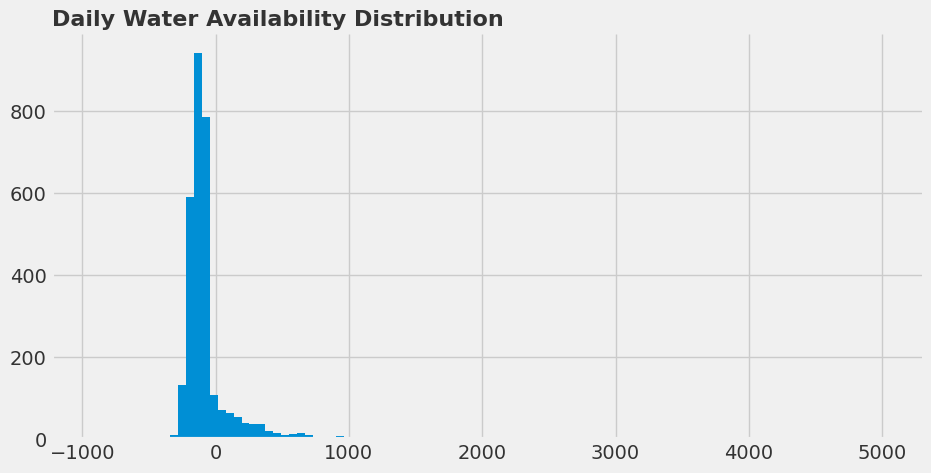

In [58]:
plt.title('Daily Water Availability Distribution')
# df['min_water_availability'].hist()
# df['max_water_availability'].hist()
df['water_availability'].hist(bins=100);

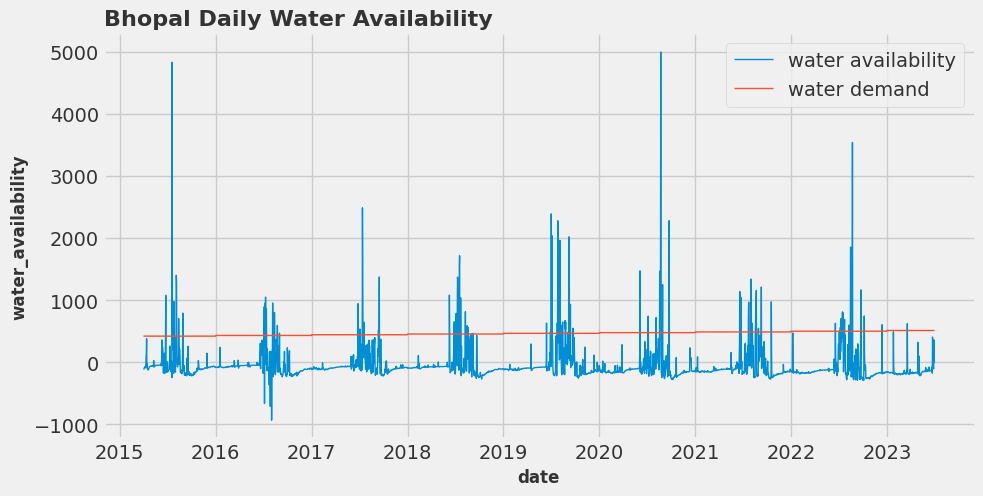

In [59]:
plt.title('Bhopal Daily Water Availability')
# sns.lineplot(x=df['date'], y=df['min_water_availability'])
# sns.lineplot(x=df['date'], y=df['max_water_availability'])

sns.lineplot(x=df['date'], y=df['water_availability'], label='water availability')
sns.lineplot(x=df['date'], y=daily_water_demand, label='water demand');

In [60]:
# Save the dataframe
file = os.path.join(final_data_directory, "GLDAS_GFS_population_Bhopal_2015_2023_final.csv")
df.to_csv(file, index=False, encoding='utf-8-sig')

In [5]:
file = os.path.join(final_data_directory, "GLDAS_GFS_population_Bhopal_2015_2023_final.csv")
df = pd.read_csv(file)

In [6]:
df.tail(100)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,...,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum (mm),year,population,water_availability
2913,2023-03-23,29.117073,0.005250,20.729930,1.870306,-1.101268,18.255866,0.014681,0.009706,298.743201,...,1154.689825,280.047681,5.118613,176.500250,1.116328e-06,1154.690868,0.0,2023,2565000,-183.275443
2914,2023-03-24,29.014253,0.004718,18.872460,1.781674,-1.292254,16.600959,0.012384,0.012068,299.677057,...,1152.664936,278.904204,5.032096,193.630373,1.004046e-06,1152.665256,0.0,2023,2565000,-189.784421
2915,2023-03-25,29.362583,0.004578,17.960533,1.049198,-1.248144,16.568285,0.004599,0.010449,299.779306,...,1150.542013,277.687194,4.974493,204.213539,8.216694e-07,1150.542165,0.0,2023,2565000,-190.548500
2916,2023-03-26,29.434064,0.004797,18.926898,0.865091,-1.315062,17.137841,0.022248,0.010061,299.146811,...,1148.407212,276.489028,4.918551,200.510729,6.059979e-07,1148.407573,0.0,2023,2565000,-191.389905
2917,2023-03-27,29.565422,0.005187,20.590961,1.011459,-1.212410,18.940984,0.023160,0.009084,300.107535,...,1146.295181,275.357247,4.863062,206.893624,4.481432e-07,1146.295307,0.0,2023,2565000,-189.142553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,2023-06-26,26.304192,0.017500,78.489295,4.621689,1.241421,59.124345,3.681857,0.014880,301.319386,...,1119.148058,298.015849,6.533273,103.863962,2.137695e-06,1119.159069,4.6,2023,2565000,-48.863023
3009,2023-06-27,26.609251,0.017689,78.081354,4.565200,1.555393,58.825112,3.636627,0.016214,301.113478,...,1123.364814,301.350545,6.898181,101.200953,2.175325e-06,1123.375532,4.4,2023,2565000,-104.998588
3010,2023-06-28,26.892660,0.017768,76.791421,4.170625,1.146734,60.177433,1.603568,0.016272,300.568071,...,1134.990114,311.311238,7.512892,109.385402,3.226315e-06,1135.002598,21.0,2023,2565000,362.455075
3011,2023-06-29,27.319106,0.018360,77.157611,3.962298,0.360457,62.622001,1.988386,0.017152,300.438963,...,1144.042161,317.569183,7.319170,111.313468,4.470741e-06,1144.054883,17.1,2023,2565000,300.812330


# **Split the data into the training and test datasets**

In [8]:
# Drop 'year' and 'population'
df.drop(['year', 'population'], axis=1, inplace=True)

In [9]:
# Split df into training --> from 2015 to 2021 and test datasets --> 2022 and 2023
training_df = df[df['date'] <= '2021-12-31']
test_df = df[df['date'] >= '2022-01-01']

In [63]:
training_df.head()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum (mm),water_availability
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.000000e+00,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,0.0,-112.673746
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.000000e+00,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,0.0,-111.269587
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.000000e+00,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,0.0,-106.525412
3,2015-04-04,30.046127,0.008165,30.080859,2.575579,-1.547093,24.770628,0.0,0.014474,302.893081,0.000027,8.663470e-11,0.000021,0.000022,875.300761,-72.375750,7.162284,84.828026,53.421145,0.000000e+00,302.893081,1147.826225,272.525414,4.354961,217.789598,2.082960e-07,1147.826188,0.0,-90.917171
4,2015-04-05,30.523074,0.007366,26.557658,-0.549178,-0.442961,23.765168,0.0,0.010641,302.875925,0.000883,2.446408e-07,0.000019,0.000019,874.372780,-56.206076,6.185620,66.643473,46.833714,1.183570e-09,302.875925,1146.413800,272.040991,4.340641,175.870913,1.475418e-07,1146.414677,0.0,-82.613718


In [10]:
test_df.head()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum (mm),water_availability
2467,2022-01-01,18.301797,0.007695,56.643939,-1.643093,-0.584867,22.510895,0.161284,0.009205,290.077060,0.000583,4.966073e-09,0.000009,0.000013,925.772455,-48.311597,0.657873,31.095981,33.021660,0.000000e+00,290.077060,1227.250693,301.478202,5.937676,113.089359,0.000004,1227.251248,0.0,-144.592233
2468,2022-01-02,17.857911,0.007962,60.310401,-1.488433,-0.309931,22.516758,0.353586,0.009172,290.599721,0.001536,1.153309e-08,0.000010,0.000015,925.406073,-55.187316,-0.975180,31.877762,37.589088,8.377777e-11,290.599721,1226.658935,301.252813,5.921228,123.678205,0.000005,1226.660441,0.0,-150.352289
2469,2022-01-03,18.092715,0.008071,60.935248,-1.673682,-0.380697,22.784478,0.337878,0.007890,290.406086,0.001035,1.809019e-08,0.000010,0.000015,925.034798,-62.355969,-2.724797,31.577438,37.867395,0.000000e+00,290.406086,1226.006339,300.971606,5.913948,129.075918,0.000005,1226.007440,0.0,-150.702989
2470,2022-01-04,18.292371,0.008296,62.098417,-1.343831,-0.674816,22.987746,0.258376,0.007410,291.271647,0.000467,3.117638e-09,0.000012,0.000019,924.655692,-60.987741,0.904757,24.433613,45.746040,0.000000e+00,291.271647,1225.183216,300.527585,5.874026,132.073751,0.000006,1225.183737,0.0,-160.638416
2471,2022-01-05,17.985828,0.008540,64.981693,-1.196424,-0.982014,22.589843,0.251203,0.010040,292.962801,0.033704,9.308131e-07,0.000012,0.000019,924.263587,-34.518997,9.098005,18.855093,46.549773,1.365109e-06,292.962801,1225.057776,300.794211,6.123887,109.031300,0.000006,1225.091514,0.2,-158.698003


In [11]:
print("Shape of training dataset: ", training_df.shape)
print("Shape of test dataset: ", test_df.shape)

Shape of training dataset:  (2467, 29)
Shape of test dataset:  (546, 29)


In [13]:
# Save the dataframe
file = os.path.join(final_data_directory, "train_bhopal.csv")
training_df.to_csv(file, index=False, encoding='utf-8-sig')

file = os.path.join(final_data_directory, "test_bhopal.csv")
test_df.to_csv(file, index=False, encoding='utf-8-sig')